In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

In [9]:
import sys
!{sys.executable} -m pip install keras-tuner -q

In [11]:
from tensorflow import keras
from keras import layers
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(784,)))
    
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
            activation=hp.Choice('activation', ['relu', 'tanh'])
        ))
    
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='my_dir',
    project_name='fashion_mnist_tuning'
)

tuner.search(x_train, y_train,
             epochs=10,
             validation_data=(x_test, y_test))

Trial 15 Complete [00h 00m 16s]
val_accuracy: 0.8899999856948853

Best val_accuracy So Far: 0.8899999856948853
Total elapsed time: 00h 03m 42s


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Найкращі гіперпараметри:
- Кількість шарів: {best_hps.get('num_layers')}
- Кількість нейронів у шарах: {[best_hps.get(f'units_{i}') for i in range(best_hps.get('num_layers'))]}
- Активація: {best_hps.get('activation')}
- Швидкість навчання: {best_hps.get('learning_rate')}
""")


Найкращі гіперпараметри:
- Кількість шарів: 2
- Кількість нейронів у шарах: [192, 256]
- Активація: relu
- Швидкість навчання: 0.001430113474396025



In [19]:
model = tuner.hypermodel.build(best_hps)
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0001)
callbacks = [early_stopping, reduce_lr]

history = model.fit(x_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7807 - loss: 0.6109 - val_accuracy: 0.8492 - val_loss: 0.4089 - learning_rate: 0.0014
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - accuracy: 0.8643 - loss: 0.3670 - val_accuracy: 0.8642 - val_loss: 0.3663 - learning_rate: 0.0014
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.8817 - loss: 0.3238 - val_accuracy: 0.8719 - val_loss: 0.3527 - learning_rate: 0.0014
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.8878 - loss: 0.3040 - val_accuracy: 0.8753 - val_loss: 0.3454 - learning_rate: 0.0014
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.8930 - loss: 0.2857 - val_accuracy: 0.8763 - val_loss: 0.3408 - learning_rate: 0.0014
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8990 - loss: 0.2699 - val_accuracy: 0.8691 - val_loss: 0.3628 - learning_rate: 0.0014
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.9018 - loss:

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 192)                 │         150,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 608,096 (2.32 MB)

 Trainable params: 202,698 (791.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 405,398 (1.55 MB)

In [25]:
model.save('fashion_mnist_model_tuned.keras')

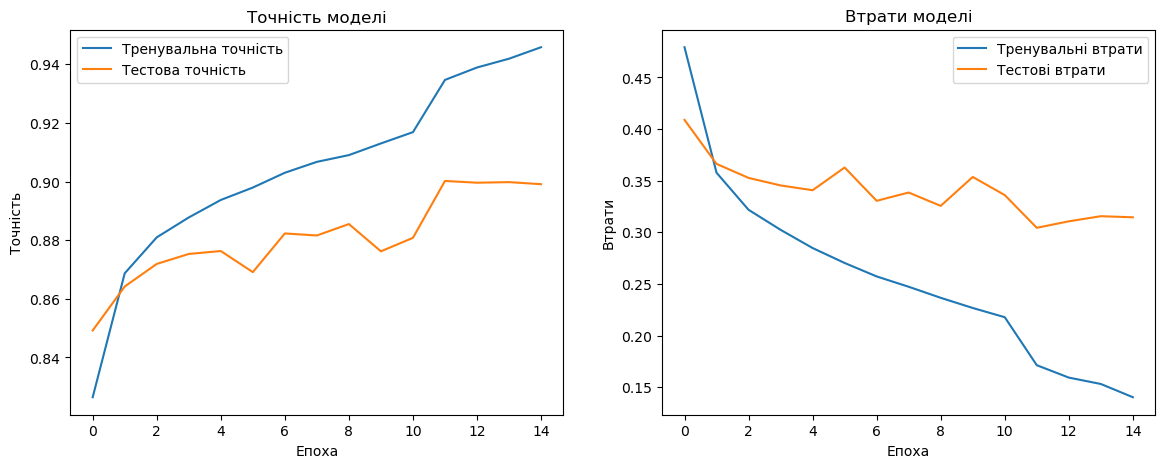

In [27]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Тренувальна точність')
plt.plot(history.history['val_accuracy'], label='Тестова точність')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Тренувальні втрати')
plt.plot(history.history['val_loss'], label='Тестові втрати')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.show()

In [29]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.82      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.82      0.83      0.82      1000
           5       0.98      0.97      0.98      1000
           6       0.73      0.73      0.73      1000
           7       0.94      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



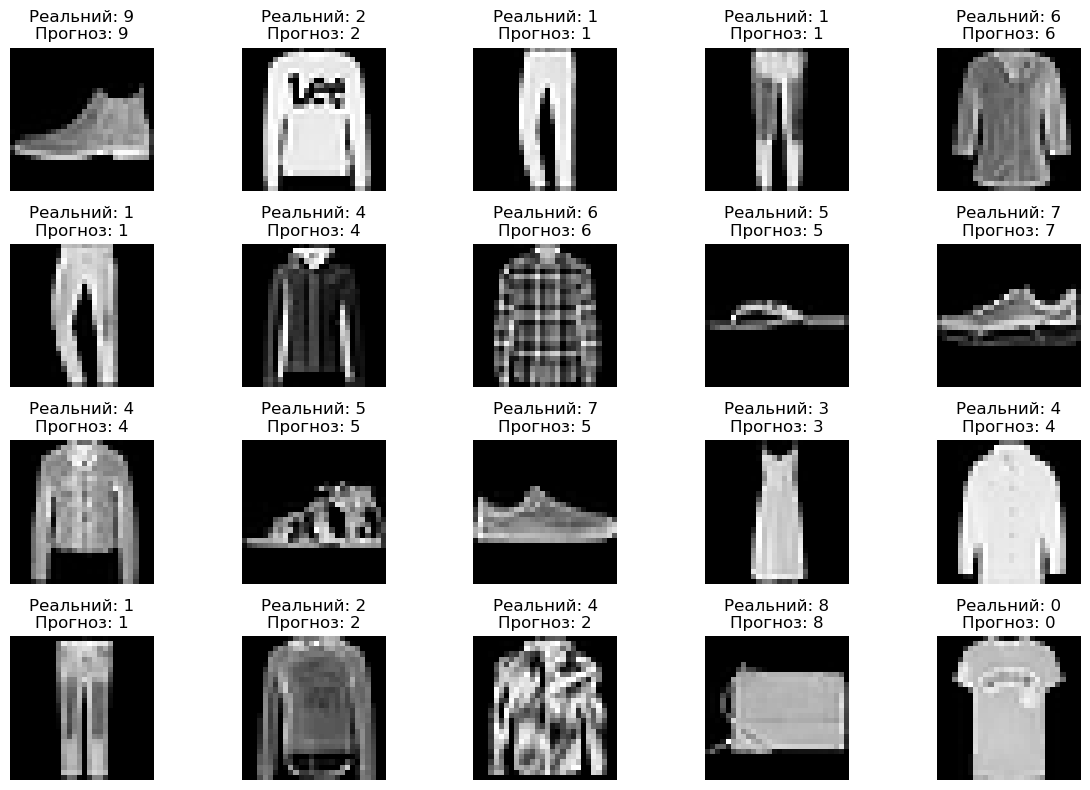

In [33]:
num_rows = 4
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(12, 8))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Реальний: {y_test[i]}\nПрогноз: {y_pred_classes[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()